# Treatment Effect of Ozempic on Obesity and Hypertension
**Icey Xue**  
02/21/2024

## 0  Data Preparation

In [303]:
import pandas as pd
# import py7zr
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [1]:
# unzip data (original data is compressed in .7z file)
# with py7zr.SevenZipFile("longyear-obese-hypertensive-medical-claims.7z", mode='r') as archive:
#    archive.extractall(path="data")

# with py7zr.SevenZipFile("longyear-obese-hypertensive-prescriptions.7z", mode='r') as archive:
#    archive.extractall(path="data")

In [3]:
medical_data = pd.read_csv("longyear-obese-hypertensive-medical-claims.csv")
medical_data.head() # preview data

,journey_id,episode_id,visit_id,encounter_id,claim_date,patient_state,patient_short_zip,patient_age,patient_gender,place_of_service,...,diag_4,diag_5,rev_center_code,rev_center_units,proc_code,proc_modifier,proc_units,line_charge,claim_charge,smart_allowed
0,00006390c96ebfffed580074c35a16a7,d5e15811af1d772f54af52f3560be0a5,f22b7ab885c44afae5449d74f8498f53aea1b2cfa79598...,d5a7dc61071d977cef9ff762973d360f4bcf15a19790d9...,2020-07-13,CA,922.0,55.0,M,Home,...,NaN,NaN,NaN,1.0,A6549,NU,2.0,300.00,300.00,974.13
1,00006390c96ebfffed580074c35a16a7,d5e15811af1d772f54af52f3560be0a5,f22b7ab885c44afae5449d74f8498f53aea1b2cfa79598...,d5a7dc61071d977cef9ff762973d360f4bcf15a19790d9...,2020-07-13,CA,922.0,55.0,M,Home,...,NaN,NaN,NaN,1.0,A6549,NU,2.0,300.00,300.00,974.13
2,00006390c96ebfffed580074c35a16a7,e25e5285e4f66d35c9840bf4e040fe73,3f45ba8ebef02b0c09b09e864e57ba5ee9d6bc9acf1c39...,c60da949b58f0351c8781c062f65d92bce76d9532d1632...,2023-07-19,CA,922.0,60.0,M,Office,...,L03115,L03116,NaN,1.0,3074F,NaN,1.0,0.00,0.00,46.57
3,00006390c96ebfffed580074c35a16a7,e25e5285e4f66d35c9840bf4e040fe73,3f45ba8ebef02b0c09b09e864e57ba5ee9d6bc9acf1c39...,c60da949b58f0351c8781c062f65d92bce76d9532d1632...,2023-07-19,CA,922.0,60.0,M,Office,...,L03115,L03116,NaN,1.0,3078F,NaN,1.0,0.00,0.00,56.38
4,00006d564a4718c744f1bbf1b6c5f8c3,42ba4419d9ad7c9293d76686fb608f10,9e4534892128401c693a6ab2ea758cd6a0a6484972168b...,da5cef18317c14180ed561a84001d8a033d724d541a2c0...,2023-08-11,CA,900.0,55.0,F,Independent Laboratory,...,NaN,NaN,NaN,1.0,80053,NaN,1.0,88.07,88.07,15.16


In [4]:
presciption_data = pd.read_csv("longyear-obese-hypertensive-prescriptions.csv.csv")
presciption_data.head()

,journey_id,cohort_id,claim_id,patient_gender,patient_state,patient_zip,patient_dob,pharmacy_npi,pharmacist_npi,prescriber_npi,...,bin,plan_pay,reject_code_1,reject_code_3,reject_code_4,reject_code_5,ndc,active,start_date,end_date
0,00006390c96ebfffed580074c35a16a7,16,60618bd8d37311da702bf9349e76f8c26d515c082e136f...,M,CA,922,1961-01-01,1215361126,None,1750479168,...,022659,NaN,None,None,None,None,47335067381,True,190001,None
1,00006390c96ebfffed580074c35a16a7,16,dbeb47defd161331e43f4e359e8d43e4ef7546ff58359b...,M,CA,922,1961-01-01,1215361126,None,1750479168,...,022659,NaN,None,None,None,None,47335067381,True,190001,None
2,00006390c96ebfffed580074c35a16a7,16,02927d081fad10afffcba79bad27f94ff52c98e968aaec...,M,CA,922,1961-01-01,1215361126,None,1750479168,...,022659,NaN,None,None,None,None,47335067381,True,190001,None
3,00006390c96ebfffed580074c35a16a7,16,a412c986e2503a5140ed1482e88b5ec50feeedaf2d89ec...,M,CA,922,1961-01-01,1215361126,None,1750479168,...,022659,NaN,None,None,None,None,47335067381,True,190001,None
4,00006390c96ebfffed580074c35a16a7,16,b65634edd78998753fe9606b142b2fff7765d6c576973c...,M,CA,922,1961-01-01,1215361126,None,1750479168,...,022659,NaN,None,None,None,None,65862059805,True,190001,None


### Data Dictionary
> Useful variables are in bold.

| Data Element       | Description                                              | Values                                     |
|--------------------|----------------------------------------------------------|--------------------------------------------|
| **JOURNEY_ID**         | Unique, anonymized patient identifier. Consistent across an entire patient journey | Note, this is the key that can be used to match between two files provided |
| VISIT_ID           | Visit identifier, visits may include multiple encounters |                                            |
| ENCOUNTER_KEY      | Encounter identified, typically the locus around which claims are dropped. Multiple encounters may look similar with revcode or procedure changes. | |
| **CLAIM_DATE**         | Date that the claim was made - typically within days of the date of service. | |
| STATE              | Two letter USPS code for State in which the service was performed | AK, AR, AZ, etc                          |
| **patient_short_zip**  | First 3 digits, as a string, of the USPS zip code for the location at which the service was performed. | 801, 802, 308, for full list, see Sheet 3 |
| HCP_NPI            | NPI number of the provider that performed the service or procedure | |
| HCP_REF_NPI        | NPI number of the provider that referred the encounter | |
| HCO_NPI            | Organizational NPI where the service was rendered | |
| PAYER_CHANNEL      | The type of payer responsible for paying the claim | Medicare, Medicaid, Commercial |
| **DIAG_1**             | ICD-10CM Code for Primary Diagnosis | G43809 = G43.809 |
| **DIAG_2**             | ICD-10CM Code for Secondary Diagnosis | |
| **DIAG_3**             | ICD-10CM Code for Tertiary Diagnosis | |
| **DIAG_4**             | ICD-10CM Code for 4th Diagnosis | |
| **DIAG_5**             | ICD-10CM Code for 5th Diagnosis | |
| PROC               | CPT Code for any Procedure Billed | |
| PROC_UNITS         | Number of units billed for a procedure | |
| MODIFIER           | Any CMS modifier reported for the procedure | RJ |
| CHARGE             | Amount charged for the encounter | $43.23 |
| REV_CENTER_CODE    | Revenue Center Code for non-procedural charges | |
| REV_CENTER_UNITS   | Number of units billed for a given Revenue Center Code | |
| PLACE_OF_SERVICE   | HIPAA standard place of service code | See Sheet2 |
| PAYER_NAME         | String name of the payer billed for the service | |
| **VISIT_TYPE**         | Type of visit where the services were rendered | 'Outpatient Visit', 'Inpatient Visit','Non-hospital institution Visit', 'Laboratory Visit', 'Home Visit','Pharmacy Visit', 'Emergency Room Visit', 'Ambulance Visit' |


In [5]:
medical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554697 entries, 0 to 554696
Data columns (total 34 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   journey_id         554697 non-null  object 
 1   episode_id         554697 non-null  object 
 2   visit_id           553084 non-null  object 
 3   encounter_id       554697 non-null  object 
 4   claim_date         554697 non-null  object 
 5   patient_state      554697 non-null  object 
 6   patient_short_zip  554684 non-null  float64
 7   patient_age        548688 non-null  float64
 8   patient_gender     554697 non-null  object 
 9   place_of_service   430588 non-null  object 
 10  visit_type         534381 non-null  object 
 11  payor              541807 non-null  object 
 12  payor_channel      521324 non-null  object 
 13  ref_npi            264500 non-null  float64
 14  hcp_npi            386656 non-null  float64
 15  hcp_taxonomy       380893 non-null  object 
 16  hc

In [6]:
medical_data = medical_data.drop_duplicates()
medical_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 501073 entries, 0 to 554696
Data columns (total 34 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   journey_id         501073 non-null  object 
 1   episode_id         501073 non-null  object 
 2   visit_id           499609 non-null  object 
 3   encounter_id       501073 non-null  object 
 4   claim_date         501073 non-null  object 
 5   patient_state      501073 non-null  object 
 6   patient_short_zip  501060 non-null  float64
 7   patient_age        495729 non-null  float64
 8   patient_gender     501073 non-null  object 
 9   place_of_service   390618 non-null  object 
 10  visit_type         483308 non-null  object 
 11  payor              489132 non-null  object 
 12  payor_channel      470364 non-null  object 
 13  ref_npi            239452 non-null  float64
 14  hcp_npi            353456 non-null  float64
 15  hcp_taxonomy       348413 non-null  object 
 16  hc

In [7]:
presciption_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 894623 entries, 0 to 894622
Data columns (total 48 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   journey_id                     894623 non-null  object 
 1   cohort_id                      894623 non-null  int64  
 2   claim_id                       894623 non-null  object 
 3   patient_gender                 894623 non-null  object 
 4   patient_state                  894623 non-null  object 
 5   patient_zip                    894623 non-null  object 
 6   patient_dob                    894623 non-null  object 
 7   pharmacy_npi                   894623 non-null  object 
 8   pharmacist_npi                 894623 non-null  object 
 9   prescriber_npi                 894623 non-null  object 
 10  primary_care_npi               894623 non-null  object 
 11  group_id                       894623 non-null  object 
 12  date_of_service               

In [8]:
presciption_data = presciption_data.drop_duplicates()
presciption_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 893390 entries, 0 to 894622
Data columns (total 48 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   journey_id                     893390 non-null  object 
 1   cohort_id                      893390 non-null  int64  
 2   claim_id                       893390 non-null  object 
 3   patient_gender                 893390 non-null  object 
 4   patient_state                  893390 non-null  object 
 5   patient_zip                    893390 non-null  object 
 6   patient_dob                    893390 non-null  object 
 7   pharmacy_npi                   893390 non-null  object 
 8   pharmacist_npi                 893390 non-null  object 
 9   prescriber_npi                 893390 non-null  object 
 10  primary_care_npi               893390 non-null  object 
 11  group_id                       893390 non-null  object 
 12  date_of_service               

In [9]:
medical_data.describe()

,patient_short_zip,patient_age,ref_npi,hcp_npi,hco_npi,rev_center_code,rev_center_units,proc_units,line_charge,claim_charge,smart_allowed
count,501060.000000,495729.000000,2.394520e+05,3.534560e+05,4.964480e+05,91425.00000,499539.000000,499373.00000,501072.000000,501072.000000,501072.000000
mean,907.465056,59.519143,1.501658e+09,1.507942e+09,1.486252e+09,447.89260,1.248701,4.30926,487.760654,487.760654,191.618636
std,40.733060,9.922648,2.870132e+08,2.825938e+08,2.862957e+08,424.14222,2.528138,54.87620,3572.616958,3572.616958,514.505873
min,74.000000,30.000000,1.003001e+09,1.003001e+09,1.003006e+09,1.00000,-1.000000,0.00000,0.000000,0.000000,0.000000
25%,900.000000,55.000000,1.255425e+09,1.265575e+09,1.245444e+09,301.00000,1.000000,1.00000,10.000000,10.000000,18.320000
50%,911.000000,60.000000,1.508914e+09,1.518997e+09,1.467961e+09,320.00000,1.000000,1.00000,69.000000,69.000000,76.060000
75%,922.000000,65.000000,1.740354e+09,1.740354e+09,1.720514e+09,521.00000,1.000000,1.00000,200.000000,200.000000,183.630000
max,999.000000,80.000000,1.992999e+09,1.992996e+09,1.992995e+09,3103.00000,730.000000,11038.00000,640000.000000,640000.000000,45035.960000


In [10]:
presciption_data.describe()

,cohort_id,ndc11,number_of_refills_authorized,quantity_prescribed_original,quantity_dispensed,fill_number,days_supply,coupon_value_amount,pharmacy_submitted_cost,patient_pay,copay_coinsurance,plan_pay,ndc,start_date
count,893390.000000,8.933900e+05,848286.000000,321117.000000,8.933830e+05,893390.000000,893390.000000,5.0,7.838500e+05,601083.000000,410861.000000,491141.000000,8.933900e+05,893390.000000
mean,16.065885,3.913838e+10,2.497853,10.989208,7.150411e+01,0.856571,41.072302,99.0,4.547539e+02,10.878673,7.071637,167.365646,3.913838e+10,190740.306160
std,0.248081,2.808682e+10,6.865188,84.448469,3.591752e+03,1.601548,29.709809,0.0,4.809737e+04,96.613683,59.729186,802.591465,2.808682e+10,2829.338106
min,16.000000,2.143301e+06,-1.000000,0.000000,0.000000e+00,0.000000,0.000000,99.0,-7.370000e+00,-189.700000,-3198.400000,-1458.620000,2.143301e+06,190001.000000
25%,16.000000,9.046999e+08,0.000000,0.000000,3.000000e+01,0.000000,30.000000,99.0,2.796000e+01,0.000000,0.000000,2.290000,9.046999e+08,190001.000000
50%,16.000000,4.948305e+10,1.000000,0.000000,3.000000e+01,0.000000,30.000000,99.0,9.520000e+01,0.000000,1.350000,13.580000,4.948305e+10,190001.000000
75%,16.000000,6.586206e+10,3.000000,0.000000,9.000000e+01,1.000000,50.000000,99.0,3.220000e+02,4.000000,4.150000,36.290000,6.586206e+10,190001.000000
max,17.000000,9.920701e+10,99.000000,10000.000000,3.390291e+06,99.000000,999.000000,99.0,4.252220e+07,25598.020000,6923.160000,50307.120000,9.920701e+10,202308.000000


## 1  Exploratory Data Analysis (EDA)

#### 1. Medical Claim Dataset

In [11]:
medical_data['journey_id'].nunique() # number of total patients

24481

Diag appreances:

In [12]:
# select 'diag_' columns
diag_columns = [col for col in medical_data.columns if col.startswith('diag_')]
diag_df = medical_data[diag_columns]

# combine all diagnoses
diag_list = diag_df.values.flatten().tolist()
diag_list = [x[:3] for x in diag_list if pd.notna(x)] # keep only first 3 digits

# count each frequency and sort desc
from collections import Counter
diag_counts = Counter(diag_list)
diag_counts_desc = pd.DataFrame(diag_counts.most_common())
diag_counts_desc.columns = ['diag','count']
diag_counts_desc.head(10)

,diag,count
0,E11,187927
1,I10,162129
2,E78,92280
3,Z00,77507
4,E66,57379
5,Z68,44014
6,M25,40977
7,M54,39853
8,N18,26412
9,Z12,26320


**Code Interpretation:**

<span style="color:red;">I10  Essential (primary) hypertension</span>

E11  Type 2 diabetes mellitus

E78  Disorders of lipoprotein metabolism and other lipidemias

N18  Chronic kidney disease (CKD)

I25  Chronic ischemic heart disease

M54  Dorsalgia

<span style="color:red;">E66  Overweight and obesity</span>

<span style="color:red;">Z68  Body mass index [BMI] high</span>

M25  Joint disorders

M54  Dorsalgia (back pain)

**Codes for Obesity and Hypertension:**
- Obesity: https://www.icd10data.com/search?s=Obesity
    - E66, 099, Z68

- Hypertension: https://www.icd10data.com/search?s=Hypertensive
    - I10, I1A, I11, I12, I12, I13, I14, I15, I16

In [13]:
# select medical claims data only for targeted patients with Obesity and Hypertension
patients_with_disease = medical_data[
          medical_data['diag_1'].str.startswith(("E66","Z68","I10","I1A","I11","I12","I13","I14","I15","I16"))|
          medical_data['diag_2'].str.startswith(("E66","Z68","I10","I1A","I11","I12","I13","I14","I15","I16"))|
          medical_data['diag_3'].str.startswith(("E66","Z68","I10","I1A","I11","I12","I13","I14","I15","I16"))|
          medical_data['diag_4'].str.startswith(("E66","Z68","I10","I1A","I11","I12","I13","I14","I15","I16"))|
          medical_data['diag_5'].str.startswith(("E66","Z68","I10","I1A","I11","I12","I13","I14","I15","I16"))
     ]['journey_id'].unique().tolist()

data_patients = medical_data[medical_data['journey_id'].isin(patients_with_disease)]

Age distribution:

In [14]:
# keep only patients aged 40-75 according to requirement
data_patients = data_patients[(data_patients['patient_age'] >= 40) & (data_patients['patient_age'] <= 75)]

In [15]:
data_patients['journey_id'].nunique() # number of total patients after filter

18180

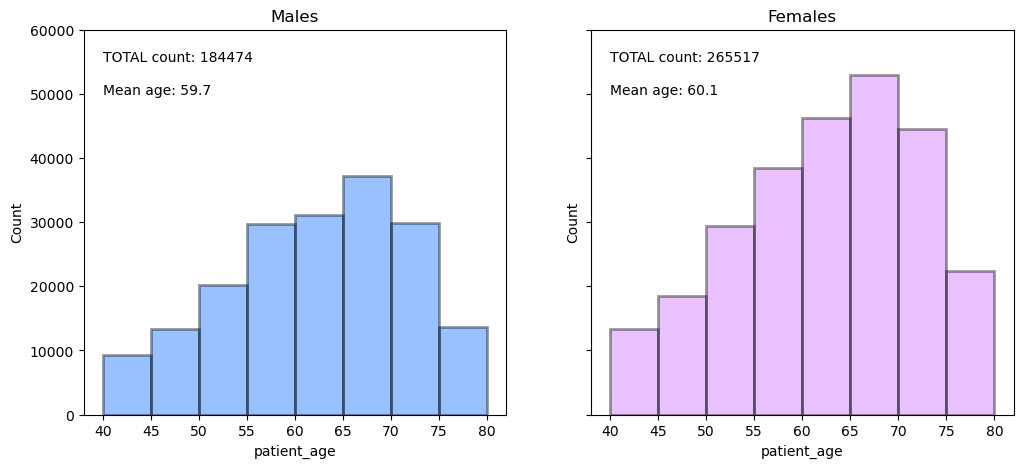

In [16]:
males_age = data_patients[data_patients['patient_gender']=='M']['patient_age'] # subset with males age
females_age = data_patients[data_patients['patient_gender']=='F']['patient_age'] # subset with females age

age_bins = range(40,81,5)
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharey=True)

# males histogram
sns.distplot(males_age, bins=age_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(age_bins)
ax1.set_ylim(top=60000)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(40,55000, "Total count: {}".format(males_age.count()))
ax1.text(40,50000, "Mean age: {:.1f}".format(males_age.mean()))

# females histogram
sns.distplot(females_age, bins=age_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(age_bins)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(40,55000, "Total count: {}".format(females_age.count()))
ax2.text(40,50000, "Mean age: {:.1f}".format(females_age.mean()))

plt.show()

States, Zip code, Visit Type, and Cliam Date:

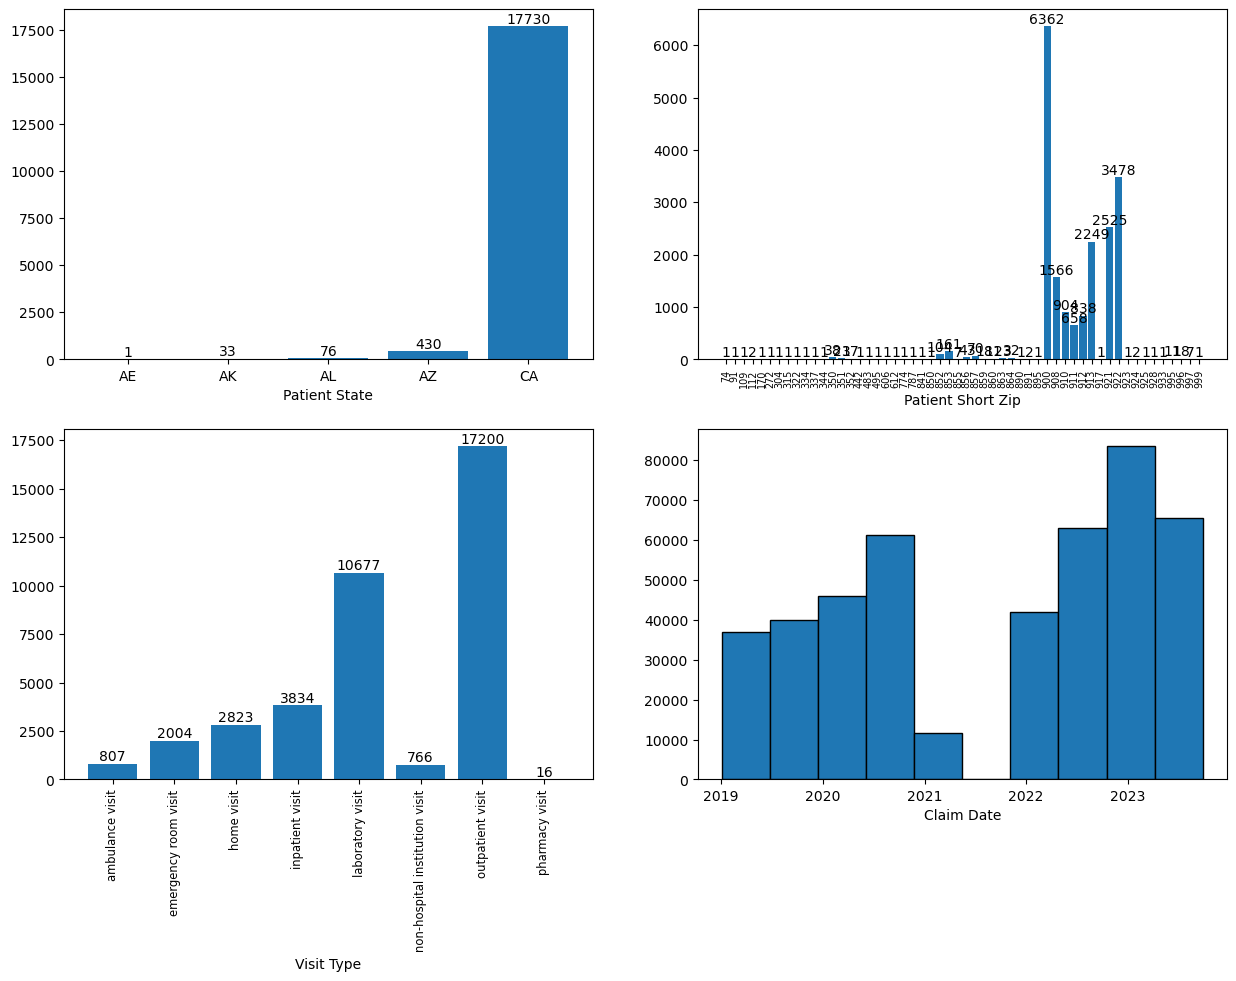

In [103]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# count by state
patient_state_cnt = data_patients.groupby('patient_state')['journey_id'].nunique()

axs[0, 0].bar(patient_state_cnt.index, patient_state_cnt.values)
axs[0, 0].set_xlabel('Patient State')
for i, v in enumerate(patient_state_cnt):
    axs[0, 0].text(i, v, f'{v:.0f}', ha='center', va='bottom')

# count by zip
patient_zip_cnt = data_patients.groupby('patient_short_zip')['journey_id'].nunique()
patient_zip_cnt.index = patient_zip_cnt.index.astype(int).astype(str)

axs[0, 1].bar(patient_zip_cnt.index, patient_zip_cnt.values)
axs[0, 1].set_xlabel('Patient Short Zip')
axs[0, 1].set_xticklabels(patient_zip_cnt.index, fontsize='x-small', rotation=90)
for i, v in enumerate(patient_zip_cnt):
    axs[0, 1].text(i, v, f'{v:.0f}', ha='center', va='bottom')

# count by visit type
patient_vst_type_cnt = data_patients.groupby('visit_type')['journey_id'].nunique()

axs[1, 0].bar(patient_vst_type_cnt.index, patient_vst_type_cnt.values)
axs[1, 0].set_xlabel('Visit Type')
axs[1, 0].set_xticklabels(patient_vst_type_cnt.index, fontsize='small', rotation=90)
for i, v in enumerate(patient_vst_type_cnt):
    axs[1, 0].text(i, v, f'{v:.0f}', ha='center', va='bottom')

# claim date
axs[1, 1].hist(pd.to_datetime(data_patients['claim_date']), edgecolor='black')
axs[1, 1].set_xlabel('Claim Date')

plt.show()

**Zip code Interpretation:**

900  LA

922  Indio

921  SD

913  LA

908  LA

> **Discovery:**

> Most patients live in CA;  
> Most frequent visit types are outpupatient visit and laboratory visit;  
> The claim dates are after 2018 when Ozempic launched, so all data can be used for our analysis.

Correlation plot:

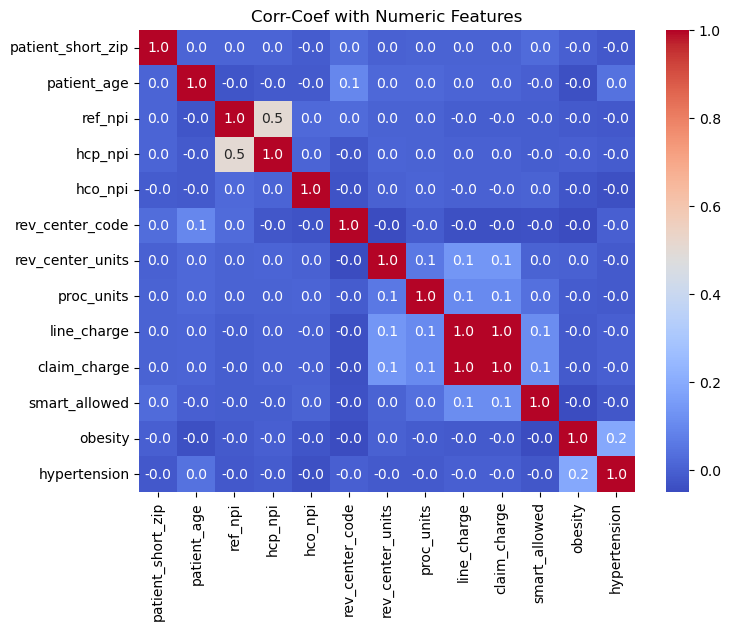

In [106]:
corr_coef = data_patients.iloc[:,1:].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_coef, annot=True, fmt=".1f", cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

> Note there's no obvious correlation between our target variables.

#### 2. Presciption Dataset

In [21]:
presciption_data['journey_id'].nunique()

14832

In [22]:
presciption_data.groupby(presciption_data['ndc']).agg({'journey_id':'nunique'}).to_csv("ndc_count.csv", index=True)
# not all prescriptions are for Ozempic, need to filter out using ndc

In [23]:
# extract unique patient identifier list
journey_id_list = data_patients['journey_id'].unique().tolist()

# NDC codes for Ozempic
# [reference: https://dailymed.nlm.nih.gov/dailymed/search.cfm?labeltype=all&query=ozempic]
ozempic_ndc_list = [169413001, 169413013, 169413211, 169413212, 169413290, 169413297, 169413602, 169413611, 169418103, 169418113, 169418190, 169418197, 169477211, 169477212, 169477290, 169477297,
                    500905138, 500905139, 50090051, 500905949]

# filter out patients
data_patients_pre = presciption_data[presciption_data['journey_id'].isin(journey_id_list) &
                                     presciption_data['ndc'].isin(ozempic_ndc_list)]

data_patients_pre['journey_id'].nunique() ### most Ozempic users are targeted patients

675

Diagnosis appreances:

In [24]:
pre_diag_df = data_patients_pre['diagnosis_code']

# combine all diagnoses
pre_diag_list = pre_diag_df.values.flatten().tolist()
pre_diag_list = [x[:3] for x in pre_diag_list if pd.notna(x)] # keep only first 3 digits

# count each frequency and sort desc
from collections import Counter
pre_diag_counts = Counter(pre_diag_list)
pre_diag_counts_desc = pd.DataFrame(pre_diag_counts.most_common())
pre_diag_counts_desc.columns = ['diagnosis_code','count']
pre_diag_counts_desc.head(10)

,diagnosis_code,count
0,Non,4717
1,E11,1372
2,E66,160
3,R73,92
4,E88,44
5,E21,35
6,I50,11
7,Z76,9
8,Z68,3
9,Z79,3


Prescription quantity:

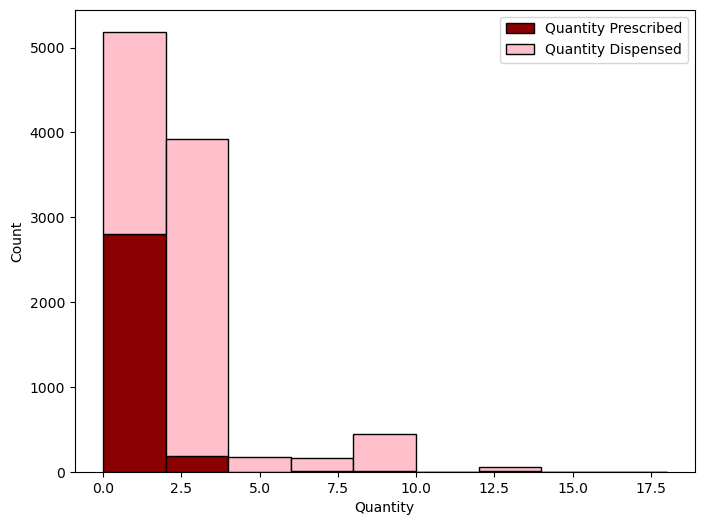

In [107]:
quantity_bins = range(0,20,2)
plt.figure(figsize=(8, 6))

# Plot stacked bar chart
plt.hist([data_patients_pre['quantity_prescribed_original'], data_patients_pre['quantity_dispensed']],
         bins=quantity_bins, stacked=True, color=['darkred', 'pink'], edgecolor='black', label=['Quantity Prescribed', 'Quantity Dispensed'])

plt.xlabel('Quantity')
plt.ylabel('Count')
plt.legend()
plt.show()

> Note that the actual dispensed quantity > prescribed quantity,  
> should use quantity_dispensed for data filtering.

Days supply:

(array([2.800e+01, 1.000e+01, 2.100e+01, 1.000e+00, 4.900e+01, 4.365e+03,
        6.950e+02, 3.100e+01, 3.450e+02, 9.000e+00, 0.000e+00, 6.440e+02,
        4.700e+01, 0.000e+00, 1.200e+01, 1.000e+00, 5.570e+02, 0.000e+00,
        1.020e+02, 4.000e+00, 1.000e+00]),
 array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
         65,  70,  75,  80,  85,  90,  95, 100, 105]),
 <BarContainer object of 21 artists>)

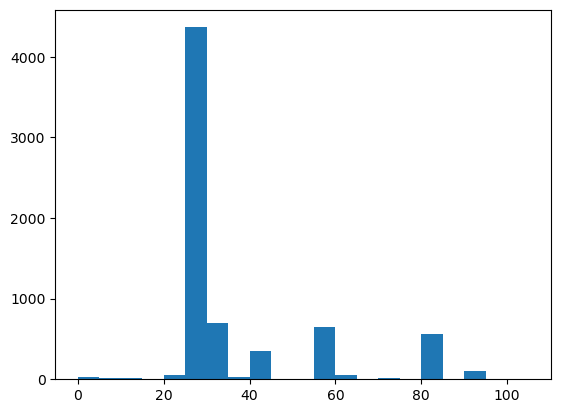

In [26]:
days_bins = range(0,110,5)
plt.hist(data_patients_pre['days_supply'], bins=days_bins)

Ozempic Start Day:

In [27]:
### since start_date and end_date are not usable:
data_patients_pre.query("date_of_service == date_authorized")['journey_id'].count()
### these 2 columns are almost the same

5869

In [28]:
data_patients_pre.query("date_of_service == 'None'")['journey_id'].count()
### use this as start day of Ozempic

0

In [29]:
data_patients_pre.query("date_authorized == 'None'")['journey_id'].count()
### don't use this

601

## 2  Data Preprocessing and Merging


### y - Dependent Variable

In [30]:
# if diag_1 ~ diag_5 contains Obesity code, obesity = 1
data_patients['obesity'] = data_patients[['diag_1','diag_2','diag_3','diag_4','diag_5']].apply(
    lambda x: any(diag.startswith(("E66","Z68")) for diag in x if pd.notnull(diag)), axis=1
).astype(int)

# if diag_1 ~ diag_5 contains Hypertension code, hypertension = 1
data_patients['hypertension'] = data_patients[['diag_1','diag_2','diag_3','diag_4','diag_5']].apply(
    lambda x: any(diag.startswith(("I10","I1A","I11","I12","I13","I14","I15","I16")) for diag in x if pd.notnull(diag)), axis=1
).astype(int)

data_patients

,journey_id,episode_id,visit_id,encounter_id,claim_date,patient_state,patient_short_zip,patient_age,patient_gender,place_of_service,...,rev_center_code,rev_center_units,proc_code,proc_modifier,proc_units,line_charge,claim_charge,smart_allowed,obesity,hypertension
4,00006d564a4718c744f1bbf1b6c5f8c3,42ba4419d9ad7c9293d76686fb608f10,9e4534892128401c693a6ab2ea758cd6a0a6484972168b...,da5cef18317c14180ed561a84001d8a033d724d541a2c0...,2023-08-11,CA,900.0,55.0,F,Independent Laboratory,...,NaN,1.0,80053,NaN,1.0,88.07,88.07,15.16,0,0
5,00006d564a4718c744f1bbf1b6c5f8c3,cad5e8635fd011bfec2b65d161b15254,3b0f0f71ac05c34ab9307c4853f1af59420c07b522cdf2...,eafff3ebf33ebe534edc66e761d9b52d1381653d9d0d57...,2019-11-01,CA,900.0,50.0,F,Office,...,NaN,1.0,72072,NaN,1.0,107.00,107.00,72.42,0,0
6,00006d564a4718c744f1bbf1b6c5f8c3,cfc123a94e0e7687f5970ef10298b4f3,b058872fef09e56b8cb2884d0efb176b40d74e0ab9958f...,40a7b91c3e29dd785065e3b6377d7f92303c442cb0df99...,2022-09-16,CA,900.0,50.0,F,Office,...,NaN,1.0,1159F,NaN,1.0,0.01,0.01,44.68,1,1
7,00006d564a4718c744f1bbf1b6c5f8c3,19bcb45f2fd320d43dd38f830984b2b9,a57068de153766ca711558b032f098755599f34648fae5...,6bc65d28fcc6a1864cd0fa9a21bee994ae9f0ad6c56469...,2022-12-23,CA,900.0,50.0,F,Office,...,NaN,1.0,71046,NaN,1.0,93.00,93.00,99.16,0,0
8,00006d564a4718c744f1bbf1b6c5f8c3,19bcb45f2fd320d43dd38f830984b2b9,822e380adc05d2abf61dcaec34262c891e5bd7da0a4cc7...,2ffddae22ec5dc0a6ee2b9ae6efdb8222acec2d649db15...,2023-01-03,CA,900.0,55.0,F,Office,...,NaN,1.0,76775,NaN,1.0,209.00,209.00,128.82,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554675,1caf0ea597f4157a3bc965a3d5f05d9d,4ca439b25fa44a1fe93168f1822f932b,d207cd5e007bd41de07417108454b7dfd4da89efe6ab4f...,34c4a705b0df12e07c0c94688f5dbe433dfb48d4590aaf...,2022-09-21,CA,900.0,65.0,M,On Campus-Outpatient Hospital,...,300.0,1.0,81001,NaN,1.0,60.00,60.00,685.23,0,0
554676,1caf0ea597f4157a3bc965a3d5f05d9d,4ca439b25fa44a1fe93168f1822f932b,b50759bee7145f4fdc8aea85b55322f1ecb11b44a665d1...,75f242ec24916a9d88a248f90e0a83382a024b167b74a7...,2022-09-09,CA,900.0,65.0,M,Inpatient Hospital,...,320.0,3.0,73630,NaN,1.0,0.00,0.00,104.13,0,1
554677,1caf0ea597f4157a3bc965a3d5f05d9d,4ca439b25fa44a1fe93168f1822f932b,f37d2371590a768bc6a25c2ca024fba872f258a2a7e002...,df0858c77938f85768da5434d99572c8ad54db727f56f5...,2022-08-03,CA,900.0,65.0,M,Independent Clinic,...,NaN,1.0,76770,26,10.0,650.00,650.00,339.34,0,0
554678,1caf0ea597f4157a3bc965a3d5f05d9d,4ca439b25fa44a1fe93168f1822f932b,c73515fd982cd87b929805faeeff745abf9231e19108a4...,f7d25075d5a376d257da8e1977b2dfdb9be1cfdc32e737...,2022-09-19,CA,900.0,65.0,M,On Campus-Outpatient Hospital,...,300.0,1.0,80048,NaN,1.0,200.00,200.00,1085.85,0,0


Check on data usability:

In [108]:
data_patients[['obesity','hypertension']].corr()

,obesity,hypertension
obesity,1.000000,0.188413
hypertension,0.188413,1.000000


> Obesity and Hypertension have a very small correlation,  
> therefore, we need to investigate Ozempic's effect on 2 diagnoses separately.

<mark>Explanation:</mark>  
> Previously, I just used 'obesity' and 'hypertension' as y.

> But this approach doesn't capture the diagnosis change caused by Ozempic.  
> So I create new y for revision.

In [183]:
# Order the data by date asc for analyzing diagnosis change
data_patients = data_patients.sort_values(by=['claim_date'])

diag_group = data_patients.groupby(['journey_id']).agg(
    {
        'obesity':['min','max','first','last'],
        'hypertension':['min','max','first','last'],
    }
)
#diag_group.columns = diag_group.columns.to_flat_index()
diag_group

obesity                hypertension      \
                                     min max first last          min max   
journey_id                                                                 
00006d564a4718c744f1bbf1b6c5f8c3       0   1     0    0            0   1   
000072bc05e31d0126475c7a3e771af1       1   1     1    1            0   0   
00011020325337a2a22fb26b6492196a       0   1     1    0            0   1   
00012bb21b3136f52c1c0774071f2ec2       0   0     0    0            1   1   
00025243850b83969606f3f2aafc2d99       0   1     0    0            0   1   
...                                  ...  ..   ...  ...          ...  ..   
1cad63bd5b82e6ce762850a948e1e615       0   0     0    0            0   1   
1cae6a96c69494ab461ffc028cb1a4b3       0   1     0    0            0   1   
1cae6fc0edfa66ef7de8d0ed8680e496       0   1     0    0            0   1   
1caf046b587b9d809260cba39fe53f04       0   0     0    0            0   1   
1caf0ea597f4157a3bc965a3d5f05d9d       0   0     0    0            0   1   

                                             
                                 first last  
journey_id                                   
00006d564a4718c744f1bbf1b6c5f8c3     1    0  
000072bc05e31d0126475c7a3e771af1     0    0  
00011020325337a2a22fb26b6492196a     1    0  
00012bb21b3136f52c1c0774071f2ec2     1    1  
00025243850b83969606f3f2aafc2d99     0    0  
...                                ...  ...  
1cad63bd5b82e6ce762850a948e1e615     0    1  
1cae6a96c69494ab461ffc028cb1a4b3     0    0  
1cae6fc0edfa66ef7de8d0ed8680e496     0    0  
1caf046b587b9d809260cba39fe53f04     0    1  
1caf0ea597f4157a3bc965a3d5f05d9d     1    0  

[18180 rows x 8 columns]

> Note that we need to drop patients without the other disease for each model.

In [185]:
# Number of patients whose obesity symptom has changed
print(len(diag_group[diag_group['obesity']['max'] != diag_group['obesity']['min']]))

# Number of patients whose hypertension symptom has changed
print(len(diag_group[diag_group['hypertension']['max'] != diag_group['hypertension']['min']]))

11309
14630


In [188]:
# Number of patients whose obesity symptom disappeared
print(len(diag_group[(diag_group['obesity']['max'] != diag_group['obesity']['min']) & (diag_group['obesity']['last'] == 0)]))

# Number of patients whose hypertension symptom disappeared
print(len(diag_group[(diag_group['hypertension']['max'] != diag_group['hypertension']['min']) & (diag_group['hypertension']['last'] == 0)]))

8212
9551


> Whether patients' symptom disppear is our real **y** for analysis.

In [192]:
# Get the target patients for analysis
patient_id_obes = diag_group[(diag_group['obesity']['max'] != 0) | (diag_group['obesity']['min'] != 0)].index.tolist() # if max_obes = min_obes = 0, the patient is not obese at all
patient_id_obes_cured = diag_group[(diag_group['obesity']['max'] != diag_group['obesity']['min']) & (diag_group['obesity']['last'] == 0)].index.tolist() # to assign y later

patient_id_hyper = diag_group[(diag_group['hypertension']['max'] != 0) | (diag_group['hypertension']['min'] != 0)].index.tolist() # if max_hyper = min_hyper = 0, the patient is not hypertensive at all
patient_id_hyper_cured = diag_group[(diag_group['hypertension']['max'] != diag_group['hypertension']['min']) & (diag_group['hypertension']['last'] == 0)].index.tolist() # to assign y later

<mark>FINAL y: 'obes_cured' & 'hyper_cured'</mark>

In [193]:
data_patients['obes_cured'] = data_patients['journey_id'].isin(patient_id_obes_cured).astype(int)
data_patients['hyper_cured'] = data_patients['journey_id'].isin(patient_id_hyper_cured).astype(int)

### Treatment d

In [194]:
# target group: patients with obesity or hypertension
data_patients_id_list = list(set(patient_id_obes) | set(patient_id_hyper)) # union of both patients
len(data_patients_id_list)

18085

In [197]:
# patients with Ozempic description
patient_id_ozempic = data_patients_pre['journey_id'].unique().tolist()
len(patient_id_ozempic)

675

> These are the patients who received Ozempic, whose d = 1

In [198]:
data_patients['Ozempic'] = data_patients['journey_id'].isin(patient_id_ozempic).astype(int)

*Previous approach 1: using claim_date after first prescription date as treatment
*Abandon because not related with 
```py
data_patients_pre = data_patients_pre[data_patients_pre['quantity_dispensed'] > 0] # make sure prescription is valid
data_patients_new = data_patients[data_patients['journey_id'].isin(data_patients_id_list)]  # keep only patients with obesity or hypertension

data_patients_new['claim_date'] = pd.to_datetime(data_patients_new['claim_date'])

# select useful columns, and keep the first date for patients' Ozempic prescription
pre_patients_start_date = data_patients_pre.groupby(['journey_id']).agg({'date_of_service': 'min'}).reset_index()
pre_patients_start_date['date_of_service'] = pd.to_datetime(pre_patients_start_date['date_of_service'])

# if claim_date >= patient's first Ozempic prescription date, treatment = 1
data_patients_new = pd.merge(data_patients_new, pre_patients_start_date, on='journey_id', how='left')
data_patients_new['Ozempic'] = data_patients_new[['claim_date','date_of_service']].apply(lambda x: 1 if x[0]>=x[1] else 0, axis=1)

# see distribution
data_patients_new.groupby('Ozempic')['journey_id'].count()

*Previous approach 2: using cliam_date BETWEEN date_of_service TO days_supply  
*abondoned because not making sense*
```py
# select useful columns, and keep the widest time range for Ozempic prescription
pre_patients_date = data_patients_pre.groupby(['journey_id', 'date_of_service']).agg({'days_supply': 'max'}).reset_index()

# calculate prescription end date
from datetime import datetime, timedelta
pre_patients_date['date_of_service'] = pd.to_datetime(pre_patients_date['date_of_service'])
pre_patients_date['days_supply'] = pre_patients_date['days_supply'].astype(int)
pre_patients_date['date_end'] = pre_patients_date[['date_of_service','days_supply']].apply(lambda x: x[0]+timedelta(days=x[1]), axis=1)
pre_patients_date
### notice there exists elapsed time window when patients temporarily stop using Ozempic

(Another calculation method)
```py
pre_journey_id_list = data_patients_pre['journey_id'].unique().tolist()
data_patients_new = data_patients[data_patients['journey_id'].isin(pre_journey_id_list)] # keep only patients with Ozempic prescription
data_patients_new['claim_date'] = pd.to_datetime(data_patients_new['claim_date'])

## Method 1:
data_patients_new['id'] = data_patients_new.reset_index().index + 1 # create unique ids for each left_row for selection
matched_id_list = []
for i in range(len(data_patients_new)-1):
    left_row = data_patients_new.iloc[i,:]
    # matching journey_id
    matching_right_rows = pre_patients_date[pre_patients_date['journey_id'] == left_row['journey_id']]
    # filter for left_rows using dates
    for right_row in matching_right_rows:
        if (left_row['claim_date'] >= right_row['date_of_service']) & (left_row['claim_date'] <= right_row['date_end']):
            matched_id = left_row['id']
            matched_id_list.append(matched_id)
data_patients_new['Ozempic'] = data_patients_new[['id']].apply(lambda x: 1 if x.isin(matched_id_list) else 0)

## Method 2: 
# creat temporary key for cross join
data_patients_new['key'] = 0
pre_patients_date['key'] = 0
cross_joined_data = pd.merge(data_patients_new, pre_patients_date, on='key').drop('key', axis=1)
# filter matched data
matched_data = cross_joined_data[(cross_joined_data['journey_id_x'] == cross_joined_data['journey_id_y']) & 
                                 (cross_joined_data['claim_date'] >= cross_joined_data['date_of_service']) & 
                                 (cross_joined_data['claim_date'] <= cross_joined_data['date_end'])]
# add Treatment column
data_patients_new['Ozempic'] = data_patients_new.index.isin(matched_data.index)

# see result
data_patients_new.groupby('Ozempic')['journey_id'].nunique()
```

```py
pre_journey_id_list = data_patients_pre['journey_id'].unique().tolist()
data_patients_new = data_patients[data_patients['journey_id'].isin(pre_journey_id_list)] # keep only patients with Ozempic prescription
data_patients_new['claim_date'] = pd.to_datetime(data_patients_new['claim_date'])

data_patients_new['Ozempic'] = 0  # Initialize all to 0

for _, right_row in pre_patients_date.iterrows():
    condition = (
        (data_patients_new['journey_id'] == right_row['journey_id']) &
        (data_patients_new['claim_date'] >= right_row['date_of_service']) &
        (data_patients_new['claim_date'] <= right_row['date_end'])
    )
    data_patients_new.loc[condition, 'Ozempic'] = 1

data_patients_new.groupby('Ozempic')['journey_id'].count()

### X - Confounders

In [203]:
# check for NaN
data_patients.isnull().sum()

journey_id                0
episode_id                0
visit_id                874
encounter_id              0
claim_date                0
patient_state             0
patient_short_zip        12
patient_age               0
patient_gender            0
place_of_service      96027
visit_type            15850
payor                 10639
payor_channel         28220
ref_npi              234547
hcp_npi              132822
hcp_taxonomy         137260
hcp_specialty        137259
hco_npi                3756
hcp_npi_list         132822
hco_npi_list           3756
diag_list               566
diag_1                  566
diag_2               112217
diag_3               179070
diag_4               227016
diag_5               296179
rev_center_code      371113
rev_center_units        942
proc_code             14203
proc_modifier        333720
proc_units             1141
line_charge               0
claim_charge              0
smart_allowed             0
obesity                   0
hypertension        

In [204]:
# fill NaN

# 1. patien_short_zip
print(data_patients[data_patients['patient_short_zip'].isnull()]['patient_state'].unique(), "\n") # see missing zip
# fill AK with 995, AZ with 852
data_patients.loc[(data_patients['patient_state'] == 'AK') & (data_patients['patient_short_zip'].isnull()), 'patient_short_zip'] = '995'
data_patients.loc[(data_patients['patient_state'] == 'AZ') & (data_patients['patient_short_zip'].isnull()), 'patient_short_zip'] = '852'

# 2. visit_type
print(data_patients[data_patients['visit_type'].isnull()]['place_of_service'].unique(), "\n")
print(data_patients.groupby(['visit_type','place_of_service'])['journey_id'].count()) # see how visit_type correlates with place_of_service
# fill:
#   'Office', Home' with 'pharmacy visit';
#   'Federally Qualified Health Center', 'On Campus-Outpatient Hospital', 'Ambulatory Surgical Center', 'Skilled Nursing Facility' with 'outpatient visit';
#   'Inpatient Hospital' with 'ambulance visit'
#    NaN, Other Place of Service' with 'other visit'
data_patients.loc[(data_patients['place_of_service'].isin(['Office','Home'])) & (data_patients['visit_type'].isnull()), 'visit_type'] = 'pharmacy visit'
data_patients.loc[(data_patients['place_of_service'].isin([
    'Federally Qualified Health Center', 'On Campus-Outpatient Hospital', 'Ambulatory Surgical Center', 'Skilled Nursing Facility'
])) & (data_patients['visit_type'].isnull()), 'visit_type'] = 'outpatient visit'
data_patients.loc[(data_patients['place_of_service'] == "Inpatient Hospital") & (data_patients['visit_type'].isnull()), 'visit_type'] = 'ambulance visit'
data_patients.loc[(data_patients['place_of_service'] == "Other Place of Service") | (data_patients['visit_type'].isnull()), 'visit_type'] = 'other visit'

# check result
data_patients.isnull().sum()

['AZ' 'AK'] 

[nan 'Other Place of Service' 'Office' 'Ambulatory Surgical Center'
 'Federally Qualified Health Center' 'On Campus-Outpatient Hospital'
 'Home' 'Skilled Nursing Facility' 'Inpatient Hospital'] 

visit_type        place_of_service                          
ambulance visit   Ambulance - Air or Water                         3
                  Ambulance - Land                              4537
                  Emergency Room - Hospital                        2
                  End-Stage Renal Disease Treatment Facility       2
                  Independent Laboratory                           7
                                                                ... 
outpatient visit  Rural Health Clinic                            650
                  Urgent Care Facility                          3181
                  Walk-in Retail Health Clinic                     5
pharmacy visit    Home                                             1
                  Office               

journey_id                0
episode_id                0
visit_id                874
encounter_id              0
claim_date                0
patient_state             0
patient_short_zip         0
patient_age               0
patient_gender            0
place_of_service      96027
visit_type                0
payor                 10639
payor_channel         28220
ref_npi              234547
hcp_npi              132822
hcp_taxonomy         137260
hcp_specialty        137259
hco_npi                3756
hcp_npi_list         132822
hco_npi_list           3756
diag_list               566
diag_1                  566
diag_2               112217
diag_3               179070
diag_4               227016
diag_5               296179
rev_center_code      371113
rev_center_units        942
proc_code             14203
proc_modifier        333720
proc_units             1141
line_charge               0
claim_charge              0
smart_allowed             0
obesity                   0
hypertension        

In [371]:
# create dummies for categorical variables
data_patients['patient_short_zip'] = data_patients['patient_short_zip'].astype(int).astype(str)
x_dummies =pd.get_dummies(data_patients[['patient_state', 'patient_short_zip', 'patient_gender', 'visit_type']], drop_first=True)

# extract time related confounders
x_dummies['claim_year'] = pd.to_datetime(data_patients['claim_date']).dt.year
x_dummies['cliam_month'] = pd.to_datetime(data_patients['claim_date']).dt.month

In [373]:
x_dummies.columns

Index(['patient_state_AK', 'patient_state_AL', 'patient_state_AZ',
       'patient_state_CA', 'patient_short_zip_112', 'patient_short_zip_170',
       'patient_short_zip_272', 'patient_short_zip_304',
       'patient_short_zip_315', 'patient_short_zip_322',
       'patient_short_zip_334', 'patient_short_zip_337',
       'patient_short_zip_344', 'patient_short_zip_350',
       'patient_short_zip_351', 'patient_short_zip_352',
       'patient_short_zip_442', 'patient_short_zip_483',
       'patient_short_zip_495', 'patient_short_zip_606',
       'patient_short_zip_612', 'patient_short_zip_74',
       'patient_short_zip_774', 'patient_short_zip_787',
       'patient_short_zip_841', 'patient_short_zip_850',
       'patient_short_zip_852', 'patient_short_zip_853',
       'patient_short_zip_855', 'patient_short_zip_856',
       'patient_short_zip_857', 'patient_short_zip_859',
       'patient_short_zip_860', 'patient_short_zip_863',
       'patient_short_zip_864', 'patient_short_zip_890',
  

### Combine and get final dataset for modeling

In [211]:
data_patients.columns

Index(['journey_id', 'episode_id', 'visit_id', 'encounter_id', 'claim_date',
       'patient_state', 'patient_short_zip', 'patient_age', 'patient_gender',
       'place_of_service', 'visit_type', 'payor', 'payor_channel', 'ref_npi',
       'hcp_npi', 'hcp_taxonomy', 'hcp_specialty', 'hco_npi', 'hcp_npi_list',
       'hco_npi_list', 'diag_list', 'diag_1', 'diag_2', 'diag_3', 'diag_4',
       'diag_5', 'rev_center_code', 'rev_center_units', 'proc_code',
       'proc_modifier', 'proc_units', 'line_charge', 'claim_charge',
       'smart_allowed', 'obesity', 'hypertension', 'obes_cured', 'hyper_cured',
       'Ozempic'],
      dtype='object')

In [374]:
data = data_patients[
    ['journey_id','Ozempic','obes_cured','hyper_cured','patient_age'] # 2 DVs, 1 Treatment, 1 confounder, and journey_id for filtering
]
data = pd.merge(data, x_dummies, left_index=True, right_index=True) # merge based on index
data = data.drop_duplicates()
data

,journey_id,Ozempic,obes_cured,hyper_cured,patient_age,patient_state_AK,patient_state_AL,patient_state_AZ,patient_state_CA,patient_short_zip_112,...,visit_type_emergency room visit,visit_type_home visit,visit_type_inpatient visit,visit_type_laboratory visit,visit_type_non-hospital institution visit,visit_type_other visit,visit_type_outpatient visit,visit_type_pharmacy visit,claim_year,cliam_month
494617,19acfd309bf03c266cdf511fe1766f50,0,0,0,65.0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,2019,1
94202,04ea4cf940703343b0926ea015807515,0,1,1,50.0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,2019,1
337723,116d6ad7e5e191774d0f5bba78392fef,0,0,1,70.0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,2019,1
485036,19247405091ff19225d32851fbe07656,0,1,1,60.0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,2019,1
41830,0219b31a6b06094a8cb43fc8113581c8,0,0,0,60.0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,2019,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114760,0601fb99b3ac30d34a92dfb9e791a038,0,1,1,65.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,2023,9
351433,1222723461625553e0decb14886b0379,0,1,1,60.0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,2023,9
134964,06fdddb46785c33c8e67f3b005c40d87,0,1,1,65.0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,2023,9
234040,0c0b7f995215b978ffc92324d5a7f343,0,1,1,75.0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,2023,9


In [375]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161104 entries, 494617 to 524815
Data columns (total 73 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   journey_id                                 161104 non-null  object 
 1   Ozempic                                    161104 non-null  int64  
 2   obes_cured                                 161104 non-null  int64  
 3   hyper_cured                                161104 non-null  int64  
 4   patient_age                                161104 non-null  float64
 5   patient_state_AK                           161104 non-null  uint8  
 6   patient_state_AL                           161104 non-null  uint8  
 7   patient_state_AZ                           161104 non-null  uint8  
 8   patient_state_CA                           161104 non-null  uint8  
 9   patient_short_zip_112                      161104 non-null  uint8  
 10  pat

See y * d distribution:

In [215]:
obes_cnt = data.groupby(['Ozempic','obes_cured']).size().reset_index(name = 'count') 
d_total_cnt = obes_cnt.groupby('Ozempic')['count'].transform('sum')
obes_cnt['proportion'] = obes_cnt['count']/d_total_cnt
obes_cnt

,Ozempic,obes_cured,count,proportion
0,0,0,63219,0.412570
1,0,1,90013,0.587430
2,1,0,2399,0.304751
3,1,1,5473,0.695249


In [217]:
hyper_cnt = data.groupby(['Ozempic','hyper_cured']).size().reset_index(name = 'count') 
d_total_cnt = hyper_cnt.groupby('Ozempic')['count'].transform('sum')
hyper_cnt['proportion'] = hyper_cnt['count']/d_total_cnt
hyper_cnt

,Ozempic,hyper_cured,count,proportion
0,0,0,53461,0.348889
1,0,1,99771,0.651111
2,1,0,2265,0.287729
3,1,1,5607,0.712271


> Seems like the proportion of patients cured is higher for the group with Ozempic prescription.

## 3  Causal Analysis Setup

### Step 0: base model

#### 1) Obesity

In [376]:
data_obes = data[data['journey_id'].isin(patient_id_obes)].drop(['hyper_cured'], axis=1).reset_index(drop=True) # only keeping target patients for Obesity
data_obes

,journey_id,Ozempic,obes_cured,patient_age,patient_state_AK,patient_state_AL,patient_state_AZ,patient_state_CA,patient_short_zip_112,patient_short_zip_170,...,visit_type_emergency room visit,visit_type_home visit,visit_type_inpatient visit,visit_type_laboratory visit,visit_type_non-hospital institution visit,visit_type_other visit,visit_type_outpatient visit,visit_type_pharmacy visit,claim_year,cliam_month
0,19acfd309bf03c266cdf511fe1766f50,0,0,65.0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,2019,1
1,04ea4cf940703343b0926ea015807515,0,1,50.0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,2019,1
2,19247405091ff19225d32851fbe07656,0,1,60.0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,2019,1
3,0219b31a6b06094a8cb43fc8113581c8,0,0,60.0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,2019,1
4,0d64f63d7fa49d75f9c3d838e7a15422,0,0,55.0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,2019,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121108,0601fb99b3ac30d34a92dfb9e791a038,0,1,65.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,2023,9
121109,1222723461625553e0decb14886b0379,0,1,60.0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,2023,9
121110,06fdddb46785c33c8e67f3b005c40d87,0,1,65.0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,2023,9
121111,0c0b7f995215b978ffc92324d5a7f343,0,1,75.0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,2023,9


In [377]:
d_obes = data_obes[['Ozempic']]
d_constant_obes = sm.add_constant(d_obes)

y_obes = data_obes['obes_cured']
print(y_obes.value_counts())

d_model_obes = sm.GLM(y_obes, d_constant_obes, family=sm.families.Binomial()).fit()
d_model_obes.summary()

1    95486
0    25627
Name: obes_cured, dtype: int64


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             obes_cured   No. Observations:               121113
Model:                            GLM   Df Residuals:                   121111
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -62429.
Date:                Wed, 21 Feb 2024   Deviance:                   1.2486e+05
Time:                        22:09:12   Pearson chi2:                 1.21e+05
No. Iterations:                     5   Pseudo R-squ. (CS):           0.001211
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2959      0.007    180.218      0.000       1.282       1.310
Ozempic        0.4089      0.035     11.615      0.000       0.340       0.478
==============================================================================
"""

In [378]:
X_obes = data_obes.drop(['journey_id','Ozempic','obes_cured'], axis=1)

full_model_obes = sm.GLM(y_obes, pd.concat([d_constant_obes, X_obes], axis=1), family=sm.families.Binomial()).fit()
full_model_obes.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             obes_cured   No. Observations:               121113
Model:                            GLM   Df Residuals:                   121057
Model Family:                Binomial   Df Model:                           55
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Wed, 21 Feb 2024   Deviance:                   4.8365e+06
Time:                        22:09:29   Pearson chi2:                 2.36e+20
No. Iterations:                   100   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                     -3.627e+16   2.07e+08  -1.75e+08      0.000   -3.63e+16   -3.63e+16
Ozempic                                    1.179e+15   8.61e+05   1.37e+09      0.000    1.18e+15    1.18e+15
patient_age                               -1.261e+13   2.04e+04  -6.16e+08      0.000   -1.26e+13   -1.26e+13
patient_state_AK                          -6.875e+15   4.44e+07  -1.55e+08      0.000   -6.87e+15   -6.87e+15
patient_state_AL                          -1.288e+16   7.38e+07  -1.74e+08      0.000   -1.29e+16   -1.29e+16
patient_state_AZ                          -7.184e+15   6.16e+07  -1.17e+08      0.000   -7.18e+15   -7.18e+15
patient_state_CA                          -9.331e+15   5.88e+07  -1.59e+08      0.000   -9.33e+15   -9.33e+15
patient_short_zip_112                      4.115e+15   7.32e+07   5.62e+07      0.000    4.11e+15    4.11e+15
patient_short_zip_170                     -4831.1624      0.000  -2.04e+07      0.000   -4831.163   -4831.162
patient_short_zip_272                      6.366e+15   7.32e+07   8.69e+07      0.000    6.37e+15    6.37e+15
patient_short_zip_304                      5.228e+14      5e+07   1.04e+07      0.000    5.23e+14    5.23e+14
patient_short_zip_315                      2.707e+15   6.81e+07   3.97e+07      0.000    2.71e+15    2.71e+15
patient_short_zip_322                     -6.033e+15   6.81e+07  -8.86e+07      0.000   -6.03e+15   -6.03e+15
patient_short_zip_334                     -2.586e+15   8.66e+07  -2.99e+07      0.000   -2.59e+15   -2.59e+15
patient_short_zip_337                     -1.867e+04      0.001  -1.99e+07      0.000   -1.87e+04   -1.87e+04
patient_short_zip_344                      6.623e+15   6.55e+07   1.01e+08      0.000    6.62e+15    6.62e+15
patient_short_zip_350                      5.189e+15    5.7e+07    9.1e+07      0.000    5.19e+15    5.19e+15
patient_short_zip_351                       4.01e+15   5.73e+07      7e+07      0.000    4.01e+15    4.01e+15
patient_short_zip_352                      2.703e+15   5.64e+07    4.8e+07      0.000     2.7e+15     2.7e+15
patient_short_zip_442                      2105.7338   8.49e-05   2.48e+07      0.000    2105.734    2105.734
patient_short_zip_483                     -1817.4764    7.9e-05   -2.3e+07      0.000   -1817.477   -1817.476
patient_short_zip_495                     -6.155e+15   6.81e+07  -9.04e+07      0.000   -6.16e+15   -6.16e+15
patient_short_zip_606                      1153.9949   6.35e-05   1.82e+07      0.000    1153.995    1153.995
patient_short_zip_612                     -5.972e+15   6.81e+07  -8.76e+07      0.000   -5.97e+15   -5.97e+15
patient_short_zip_74                      -6.439e+15   6.81e+07  -9.45e+07      0.000   -6.44e+15   -6.44e+15
pat

#### 2) Hypertension

In [379]:
data_hyper = data[data['journey_id'].isin(patient_id_hyper)].drop(['obes_cured'], axis=1).reset_index(drop=True) # only keeping target patients for hypertension
data_hyper

,journey_id,Ozempic,hyper_cured,patient_age,patient_state_AK,patient_state_AL,patient_state_AZ,patient_state_CA,patient_short_zip_112,patient_short_zip_170,...,visit_type_emergency room visit,visit_type_home visit,visit_type_inpatient visit,visit_type_laboratory visit,visit_type_non-hospital institution visit,visit_type_other visit,visit_type_outpatient visit,visit_type_pharmacy visit,claim_year,cliam_month
0,04ea4cf940703343b0926ea015807515,0,1,50.0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,2019,1
1,116d6ad7e5e191774d0f5bba78392fef,0,1,70.0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,2019,1
2,19247405091ff19225d32851fbe07656,0,1,60.0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,2019,1
3,0219b31a6b06094a8cb43fc8113581c8,0,0,60.0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,2019,1
4,0d64f63d7fa49d75f9c3d838e7a15422,0,0,55.0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,2019,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150652,0601fb99b3ac30d34a92dfb9e791a038,0,1,65.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,2023,9
150653,1222723461625553e0decb14886b0379,0,1,60.0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,2023,9
150654,06fdddb46785c33c8e67f3b005c40d87,0,1,65.0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,2023,9
150655,0c0b7f995215b978ffc92324d5a7f343,0,1,75.0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,2023,9


In [380]:
d_hyper = data_hyper[['Ozempic']]
d_constant_hyper = sm.add_constant(d_hyper)

y_hyper = data_hyper['hyper_cured']
print(y_hyper.value_counts())

d_model_hyper = sm.GLM(y_hyper, d_constant_hyper, family=sm.families.Binomial()).fit()
d_model_hyper.summary()

1    105378
0     45279
Name: hyper_cured, dtype: int64


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            hyper_cured   No. Observations:               150657
Model:                            GLM   Df Residuals:                   150655
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -92045.
Date:                Wed, 21 Feb 2024   Deviance:                   1.8409e+05
Time:                        22:09:41   Pearson chi2:                 1.51e+05
No. Iterations:                     5   Pseudo R-squ. (CS):          0.0007270
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8316      0.006    144.659      0.000       0.820       0.843
Ozempic        0.2816      0.027     10.253      0.000       0.228       0.335
==============================================================================
"""

In [381]:
X_hyper = data_hyper.drop(['journey_id','Ozempic','hyper_cured'], axis=1)

full_model_hyper = sm.GLM(y_hyper, pd.concat([d_constant_hyper, X_hyper], axis=1), family=sm.families.Binomial()).fit()
full_model_hyper.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            hyper_cured   No. Observations:               150657
Model:                            GLM   Df Residuals:                   150595
Model Family:                Binomial   Df Model:                           61
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Wed, 21 Feb 2024   Deviance:                   4.2926e+06
Time:                        22:10:04   Pearson chi2:                 2.10e+20
No. Iterations:                   100   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                      1.077e+16   1.97e+08   5.46e+07      0.000    1.08e+16    1.08e+16
Ozempic                                   -6.459e+14   8.01e+05  -8.06e+08      0.000   -6.46e+14   -6.46e+14
patient_age                               -2.324e+12   1.86e+04  -1.25e+08      0.000   -2.32e+12   -2.32e+12
patient_state_AK                          -6.218e+14   7.02e+07  -8.85e+06      0.000   -6.22e+14   -6.22e+14
patient_state_AL                           3.005e+15   4.03e+07   7.46e+07      0.000       3e+15       3e+15
patient_state_AZ                           4.945e+15    4.4e+07   1.12e+08      0.000    4.95e+15    4.95e+15
patient_state_CA                           4.191e+15   4.36e+07   9.62e+07      0.000    4.19e+15    4.19e+15
patient_short_zip_112                     -3.655e+15   4.33e+07  -8.44e+07      0.000   -3.65e+15   -3.65e+15
patient_short_zip_170                     -4.781e+15   6.63e+07  -7.21e+07      0.000   -4.78e+15   -4.78e+15
patient_short_zip_272                       -56.5118   1.43e-06  -3.94e+07      0.000     -56.512     -56.512
patient_short_zip_304                      -174.7007   2.14e-06  -8.16e+07      0.000    -174.701    -174.701
patient_short_zip_315                       -42.9785   1.61e-06  -2.67e+07      0.000     -42.978     -42.978
patient_short_zip_322                     -4.939e+15   6.63e+07  -7.45e+07      0.000   -4.94e+15   -4.94e+15
patient_short_zip_334                     -3.654e+15   5.96e+07  -6.13e+07      0.000   -3.65e+15   -3.65e+15
patient_short_zip_337                      5.391e+15   4.33e+07   1.25e+08      0.000    5.39e+15    5.39e+15
patient_short_zip_344                     -2.687e+14   3.22e+07  -8.35e+06      0.000   -2.69e+14   -2.69e+14
patient_short_zip_350                      1.296e+15   1.45e+07   8.92e+07      0.000     1.3e+15     1.3e+15
patient_short_zip_351                      2.388e+15   1.55e+07   1.54e+08      0.000    2.39e+15    2.39e+15
patient_short_zip_352                      1.507e+15   1.59e+07   9.48e+07      0.000    1.51e+15    1.51e+15
patient_short_zip_442                      4.592e+15   4.77e+07   9.63e+07      0.000    4.59e+15    4.59e+15
patient_short_zip_483                      1.428e+15   2.75e+07    5.2e+07      0.000    1.43e+15    1.43e+15
patient_short_zip_495                        28.5366   7.39e-07   3.86e+07      0.000      28.537      28.537
patient_short_zip_606                     -4.882e+15   4.77e+07  -1.02e+08      0.000   -4.88e+15   -4.88e+15
patient_short_zip_612                     -4.183e+14   6.63e+07  -6.31e+06      0.000   -4.18e+14   -4.18e+14
patient_short_zip_74                          0.4407   4.32e-07   1.02e+06      0.000       0.441       0.441
pat

### Endogeneity issues:  

Although both y ~ d models show Ozempic has a significant positive impact on curing obesity and hypertension, the effect is diluted when adding all confounders into the model. For Hypertension, the coefficient of treatment is even negative.  
Also, the model fitness is terrible, indicating that the treatment and confounders do not hold a strong explanatory ability towards y. This lack of significance could stem from endogeneity issues.

### Next steps: Double Lasso regression

- Step 1: Lasso regression on d using X, generating d_hat (treatment propensities explained by significant confounders);  

- Step 2: merge d, d_hat, and all X variables into one dataset and fit another Lasso regression model on y, only penalizing the X variables.  
    Since all the confounders' effect on treatment has already been captured by d_hat, their effect on d has been removed.  

- *Step 3: keep only the significant confounders chosen in Step 2 and reevaluate the model.  
    Now the coefficient of d will represent the **real Treatment Effect** of Ozempic on y.

## 4  Model Development: Double-Lasso / Treatment Effect Lasso

### Step 1: Lasso on d using X

#### 1) Obesity

Number of selected variables: 54
Index(['patient_age', 'patient_state_CA', 'patient_short_zip_112',
       'patient_short_zip_272', 'patient_short_zip_304',
       'patient_short_zip_315', 'patient_short_zip_322',
       'patient_short_zip_334', 'patient_short_zip_344',
       'patient_short_zip_350', 'patient_short_zip_351',
       'patient_short_zip_352', 'patient_short_zip_495',
       'patient_short_zip_612', 'patient_short_zip_74',
       'patient_short_zip_850', 'patient_short_zip_852',
       'patient_short_zip_853', 'patient_short_zip_855',
       'patient_short_zip_856', 'patient_short_zip_857',
       'patient_short_zip_859', 'patient_short_zip_860',
       'patient_short_zip_863', 'patient_short_zip_864',
       'patient_short_zip_890', 'patient_short_zip_891',
       'patient_short_zip_900', 'patient_short_zip_908',
       'patient_short_zip_910', 'patient_short_zip_911',
       'patient_short_zip_912', 'patient_short_zip_913',
       'patient_short_zip_917', 'patient_short

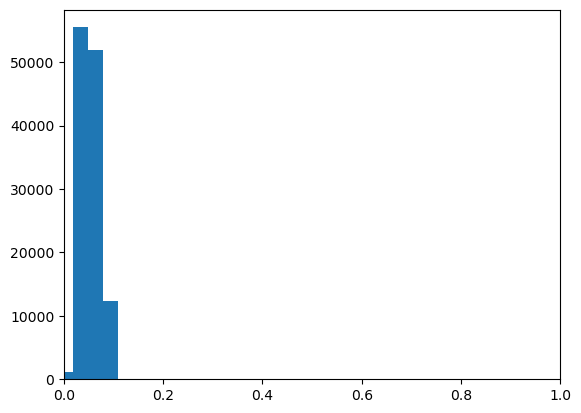

In [382]:
X_obes_scaled = StandardScaler().fit_transform(X_obes)

lasso_obes = LassoCV(cv=10).fit(X_obes_scaled, d_obes)
d_hat_obes = lasso_obes.predict(X_obes_scaled)

print("Number of selected variables:", len(X_obes.columns[lasso_obes.coef_ != 0]))
print(X_obes.columns[lasso_obes.coef_ != 0]) # selected variables

plt.hist(d_hat_obes)
plt.xlim(0, 1)
plt.show()

#### 2) Hypertension

Number of selected variables: 54
Index(['patient_age', 'patient_state_AK', 'patient_state_AL',
       'patient_state_CA', 'patient_short_zip_112', 'patient_short_zip_170',
       'patient_short_zip_322', 'patient_short_zip_334',
       'patient_short_zip_337', 'patient_short_zip_350',
       'patient_short_zip_351', 'patient_short_zip_352',
       'patient_short_zip_442', 'patient_short_zip_483',
       'patient_short_zip_606', 'patient_short_zip_612',
       'patient_short_zip_774', 'patient_short_zip_787',
       'patient_short_zip_841', 'patient_short_zip_850',
       'patient_short_zip_852', 'patient_short_zip_855',
       'patient_short_zip_856', 'patient_short_zip_857',
       'patient_short_zip_859', 'patient_short_zip_860',
       'patient_short_zip_863', 'patient_short_zip_864',
       'patient_short_zip_891', 'patient_short_zip_895',
       'patient_short_zip_900', 'patient_short_zip_908',
       'patient_short_zip_91', 'patient_short_zip_910',
       'patient_short_zip_911',

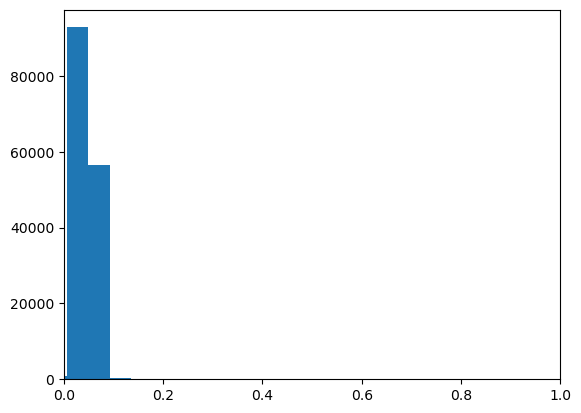

In [383]:
X_hyper_scaled = StandardScaler().fit_transform(X_hyper)

lasso_hyper = LassoCV(cv=10).fit(X_hyper_scaled, d_hyper)
d_hat_hyper = lasso_hyper.predict(X_hyper_scaled)

print("Number of selected variables:", len(X_hyper.columns[lasso_obes.coef_ != 0]))
print(X_hyper.columns[lasso_hyper.coef_ != 0]) # selected variables

plt.hist(d_hat_hyper)
plt.xlim(0, 1)
plt.show()

> A lot of confounders have effect on d. These may due to the implementation of Ozempic is largely based on region and hospitals.

> Most of the d_hat is very close to 0 (we hope to see a uniform or binary outcome), indicating a bad prediction resullt.

### Step 2: Lasso on y, keeping d and d^ unpenalized

In [231]:
# define the Partial Lasso Logistic Regression model first (from Jake)
import numpy as np
from scipy.optimize import minimize
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import log_loss

class SelectiveRegularizationLogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, penalty_indices, penalty_weights, tol=1e-4, max_iter=100):
        self.penalty_indices = penalty_indices
        self.penalty_weights = penalty_weights
        self.tol = tol
        self.max_iter = max_iter
    
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def _loss(self, coef, X, y):
        predictions = self._sigmoid(X @ coef)
        # Basic log loss
        basic_loss = log_loss(y, predictions)
        
        # Regularization term, selectively applied with L1 penalty
        reg_term = sum(self.penalty_weights[i] * abs(coef[self.penalty_indices[i]]) for i in range(len(self.penalty_indices)))
        
        return basic_loss + reg_term
    
    def fit(self, X, y):
        # Add intercept term
        X = np.hstack([np.ones((X.shape[0], 1)), X])
        
        initial_coef = np.zeros(X.shape[1])
        result = minimize(self._loss, initial_coef, args=(X, y), method='SLSQP', tol=self.tol, options={'maxiter': self.max_iter})
        
        self.coef_ = result.x
        return self
    
    def predict_proba(self, X):
        X = np.hstack([np.ones((X.shape[0], 1)), X])
        proba = self._sigmoid(X @ self.coef_)
        return np.vstack([1-proba, proba]).T
    
    def predict(self, X):
        return (self.predict_proba(X)[:, 1] > 0.5).astype(int)

#### 1) Obesity

In [397]:
df_d_hat_obes = pd.DataFrame({'d_hat_obes':d_hat_obes})
df_X_obes_scaled = pd.DataFrame(X_obes_scaled)
df_X_obes_scaled.columns = X_obes.columns

dv_obes = pd.concat([d_obes, df_d_hat_obes, df_X_obes_scaled] ,axis=1)

# partial lasso setup
alpha = 0.01
penalty_indices = list(range(3,len(X_obes.columns)+2))  # apply penalties only to X
penalty_weights = [alpha]*len(X_obes.columns)  # set penalty weights for X

full_lasso_obes = SelectiveRegularizationLogisticRegression(penalty_indices, penalty_weights).fit(dv_obes, y_obes)

In [398]:
obes_coef = full_lasso_obes.coef_
print("Number of insignificant varaibles: ", sum(1 for i in obes_coef if abs(i) < 0.01), "\n") # identify insignificant variables since the function only push down the coefficients but not setting to 0

obes_variable_names = ['(Intercept)'] + list(dv_obes.columns)
obes_coef_dict = {name: coef for name, coef in zip(obes_variable_names, obes_coef)}

for variable, coef in obes_coef_dict.items():
    print(f"{variable}: {round(coef,5)}")

Number of insignificant varaibles:  57 

(Intercept): 1.31217
Ozempic: 0.09511
d_hat_obes: 0.07117
patient_age: 0.03991
patient_state_AK: 0.00051
patient_state_AL: 0.00249
patient_state_AZ: 0.00446
patient_state_CA: -0.00598
patient_short_zip_112: 0.00238
patient_short_zip_170: -0.00042
patient_short_zip_272: 0.00224
patient_short_zip_304: 0.00222
patient_short_zip_315: 0.00052
patient_short_zip_322: -0.0018
patient_short_zip_334: -0.00208
patient_short_zip_337: -0.00042
patient_short_zip_344: 0.00118
patient_short_zip_350: 0.00149
patient_short_zip_351: 0.00117
patient_short_zip_352: 0.00163
patient_short_zip_442: -0.00042
patient_short_zip_483: -0.00042
patient_short_zip_495: -0.00161
patient_short_zip_606: -0.00042
patient_short_zip_612: -0.00183
patient_short_zip_74: -0.00144
patient_short_zip_774: -0.00042
patient_short_zip_787: -0.00042
patient_short_zip_841: -0.00042
patient_short_zip_850: 0.00208
patient_short_zip_852: -0.00386
patient_short_zip_853: 0.00355
patient_short_zip_8

#### 2) Hypertension

In [392]:
df_d_hat_hyper = pd.DataFrame({'d_hat_hyper':d_hat_hyper})
df_X_hyper_scaled = pd.DataFrame(X_hyper_scaled)
df_X_hyper_scaled.columns = X_hyper.columns

dv_hyper = pd.concat([d_hyper, df_d_hat_hyper, df_X_hyper_scaled] ,axis=1)
# partial lasso setup
alpha = 0.01
penalty_indices = list(range(3,len(X_hyper.columns)+2))  # apply penalties only to X
penalty_weights = [alpha]*len(X_hyper.columns)  # set penalty weights for X

full_lasso_hyper = SelectiveRegularizationLogisticRegression(penalty_indices, penalty_weights).fit(dv_hyper, y_hyper)

In [393]:
hyper_coef = full_lasso_hyper.coef_
print("Number of insignificant varaibles: ", sum(1 for i in hyper_coef if abs(i) < 0.01), "\n") # identify insignificant variables since the function only push down the coefficients but not setting to 0

hyper_variable_names = ['(Intercept)'] + list(dv_hyper.columns)
hyper_coef_dict = {name: coef for name, coef in zip(hyper_variable_names, hyper_coef)}

for variable, coef in hyper_coef_dict.items():
    print(f"{variable}: {round(coef,5)}")

Number of insignificant varaibles:  58 

(Intercept): 0.83898
Ozempic: 0.06396
d_hat_hyper: 0.04183
patient_age: -0.00224
patient_state_AK: 0.00076
patient_state_AL: -0.00147
patient_state_AZ: 0.00166
patient_state_CA: -0.00577
patient_short_zip_112: -0.00548
patient_short_zip_170: 0.00015
patient_short_zip_272: 0.00142
patient_short_zip_304: 0.00142
patient_short_zip_315: 0.00142
patient_short_zip_322: 0.00036
patient_short_zip_334: 0.00029
patient_short_zip_337: -0.00036
patient_short_zip_344: -0.00255
patient_short_zip_350: 8e-05
patient_short_zip_351: -0.00394
patient_short_zip_352: 0.00284
patient_short_zip_442: -0.00048
patient_short_zip_483: -0.00109
patient_short_zip_495: 0.00142
patient_short_zip_606: -0.00139
patient_short_zip_612: 0.0003
patient_short_zip_74: 0.00142
patient_short_zip_774: 0.00026
patient_short_zip_787: 0.00092
patient_short_zip_841: 0.00037
patient_short_zip_850: -0.00128
patient_short_zip_852: -0.0152
patient_short_zip_853: 0.0138
patient_short_zip_855: 0.

## 5  Model Evaluation and Interpretation

### 1. Select Lasso chosen confounders and recreate the model

#### 1) Obesity

In [412]:
dv_selected_obes = dv_obes.iloc[:, [i for i, value in enumerate(obes_coef, start=-1) if abs(value) >= 0.01 and i>=0]] # exclude intercept
X_train_obes, X_test_obes, y_train_obes, y_test_obes = train_test_split(dv_selected_obes, y_obes, test_size=0.2, random_state=724) # it's my birthday lol

X_train_obes_constant = sm.add_constant(X_train_obes)
new_model_obes = sm.GLM(y_train_obes, X_train_obes_constant, family=sm.families.Binomial()).fit()
new_model_obes.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             obes_cured   No. Observations:                96890
Model:                            GLM   Df Residuals:                    96875
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -49128.
Date:                Wed, 21 Feb 2024   Deviance:                       98256.
Time:                        22:34:13   Pearson chi2:                 9.68e+04
No. Iterations:                     6   Pseudo R-squ. (CS):            0.01639
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                         1.0428      0.041     25.557      0.000       0.963       1.123
Ozempic                                       0.4033      0.040     10.085      0.000       0.325       0.482
d_hat_obes                                    5.3475      0.755      7.083      0.000       3.868       6.827
patient_age                                   0.1267      0.009     14.246      0.000       0.109       0.144
patient_short_zip_857                         0.0997      0.015      6.490      0.000       0.070       0.130
patient_short_zip_900                        -0.0238      0.013     -1.811      0.070      -0.050       0.002
patient_short_zip_908                         0.1278      0.010     12.452      0.000       0.108       0.148
patient_short_zip_910                         0.1144      0.010     11.424      0.000       0.095       0.134
patient_short_zip_911                         0.1227      0.010     12.629      0.000       0.104       0.142
patient_short_zip_913                        -0.0681      0.009     -7.434      0.000      -0.086      -0.050
visit_type_home visit                         0.0608      0.010      6.199      0.000       0.042       0.080
visit_type_inpatient visit                    0.0735      0.009      7.964      0.000       0.055       0.092
visit_type_non-hospital institution visit     0.0513      0.010      5.285      0.000       0.032       0.070
visit_type_outpatient visit                  -0.0475      0.009     -5.341      0.000      -0.065      -0.030
cliam_month                                   0.0154      0.008      1.930      0.054      -0.000       0.031
=============================================================================================================
"""

#### 2) Hypertension

In [413]:
dv_selected_hyper = dv_hyper.iloc[:, [i for i, value in enumerate(hyper_coef, start=-1) if abs(value) >= 0.01 and i>=0]] # exclude intercept
X_train_hyper, X_test_hyper, y_train_hyper, y_test_hyper = train_test_split(dv_selected_hyper, y_hyper, test_size=0.2, random_state=724)

X_train_hyper_constant = sm.add_constant(X_train_hyper)
new_model_hyper = sm.GLM(y_train_hyper, X_train_hyper_constant, family=sm.families.Binomial()).fit()
new_model_hyper.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            hyper_cured   No. Observations:               120525
Model:                            GLM   Df Residuals:                   120511
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -73093.
Date:                Wed, 21 Feb 2024   Deviance:                   1.4619e+05
Time:                        22:34:17   Pearson chi2:                 1.21e+05
No. Iterations:                     5   Pseudo R-squ. (CS):           0.009451
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.8961      0.025     35.702      0.000       0.847       0.945
Ozempic                         0.2427      0.031      7.870      0.000       0.182       0.303
d_hat_hyper                    -1.0771      0.492     -2.191      0.028      -2.041      -0.114
patient_short_zip_852          -0.0448      0.006     -7.329      0.000      -0.057      -0.033
patient_short_zip_853           0.0279      0.007      3.859      0.000       0.014       0.042
patient_short_zip_857           0.0626      0.009      7.133      0.000       0.045       0.080
patient_short_zip_900          -0.1216      0.011    -11.195      0.000      -0.143      -0.100
patient_short_zip_908           0.0487      0.009      5.684      0.000       0.032       0.065
patient_short_zip_910           0.0567      0.008      6.956      0.000       0.041       0.073
patient_short_zip_913          -0.1012      0.007    -14.425      0.000      -0.115      -0.087
patient_short_zip_921          -0.0555      0.008     -7.121      0.000      -0.071      -0.040
patient_gender_M               -0.0595      0.006     -9.267      0.000      -0.072      -0.047
visit_type_outpatient visit    -0.0530      0.006     -8.315      0.000      -0.065      -0.040
cliam_month                     0.0170      0.006      2.692      0.007       0.005       0.029
===============================================================================================
"""

### 2. In-sample & OOS Performance

#### 1) Obesity

In [414]:
r_squared_obes = 1 - (new_model_obes.deviance / new_model_obes.null_deviance)
print(f"In-sample R-square: {r_squared_obes}")

y_pred_obes = new_model_obes.predict(sm.add_constant(X_test_obes))

# OOS
oos_deviance_obes = -2 * np.sum(y_test_obes * np.log(y_pred_obes) + 
                          (1 - y_test_obes) * np.log(1 - y_pred_obes))

r_squared_oos_obes = 1 - (oos_deviance_obes / new_model_obes.deviance)
print(f"OOS R-square: {r_squared_oos_obes}")

squared_diffs_obes = (y_pred_obes - y_test_obes)**2
mse_obes = np.mean(squared_diffs_obes)
rmse_oos_obes = np.sqrt(mse_obes)
print(f"OOS RMSE: {rmse_oos_obes}")

In-sample R-square: 0.016032500777520275
OOS R-square: 0.747086669982391
OOS RMSE: 0.407521895305694


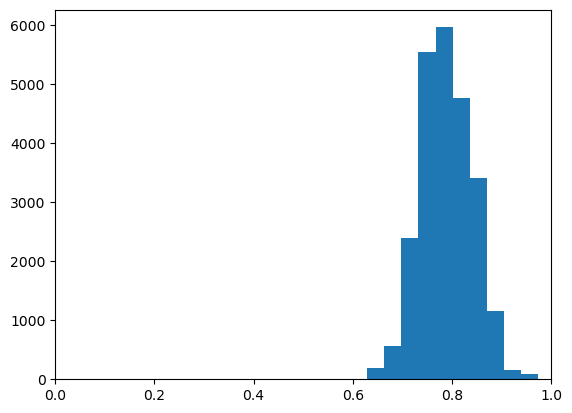

Accuracy: 0.6775791603021921


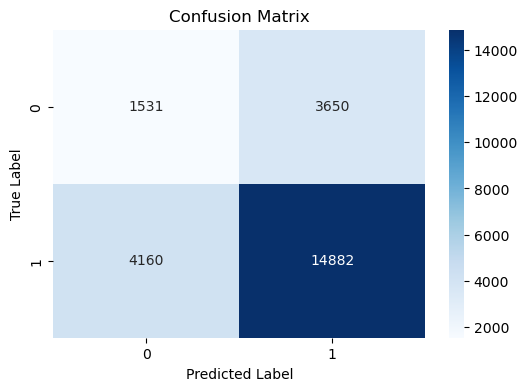

In [424]:
plt.hist(y_pred_obes)
plt.xlim(0, 1)
plt.show()

y_pred_binary_obes = (y_pred_obes > 0.75).astype(int)  # binarize predictions based on histplot

accuracy = accuracy_score(y_test_obes, y_pred_binary_obes)
print(f"Accuracy: {accuracy}")

cm = confusion_matrix(y_test_obes, y_pred_binary_obes)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [405]:
y_pred_binary_obes.value_counts()

1    36334
dtype: int64

#### 2) Hypertension

In [417]:
r_squared_hyper = 1 - (new_model_hyper.deviance / new_model_hyper.null_deviance)
print(f"In-sample R-square: {r_squared_hyper}")

y_pred_hyper = new_model_hyper.predict(sm.add_constant(X_test_hyper))

# OOS
oos_deviance_hyper = -2 * np.sum(y_test_hyper * np.log(y_pred_hyper) + 
                          (1 - y_test_hyper) * np.log(1 - y_pred_hyper))

r_squared_oos_hyper = 1 - (oos_deviance_hyper / new_model_hyper.deviance)
print(f"OOS R-square: {r_squared_oos_hyper}")

squared_diffs_hyper = (y_pred_hyper - y_test_hyper)**2
mse_hyper = np.mean(squared_diffs_hyper)
rmse_oos_hyper = np.sqrt(mse_hyper)
print(f"OOS RMSE: {rmse_oos_hyper}")

In-sample R-square: 0.007768216891064328
OOS R-square: 0.7499402046027295
OOS RMSE: 0.4563923651577482


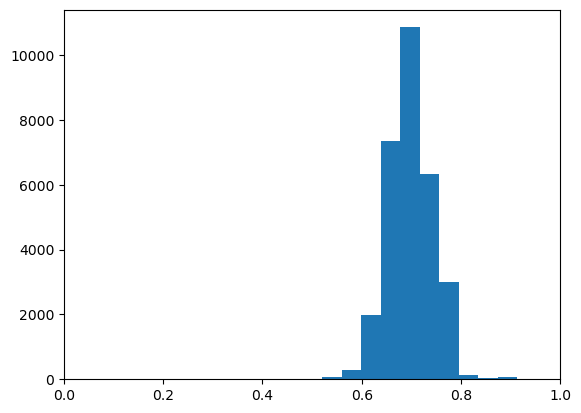

Accuracy: 0.532291251825302


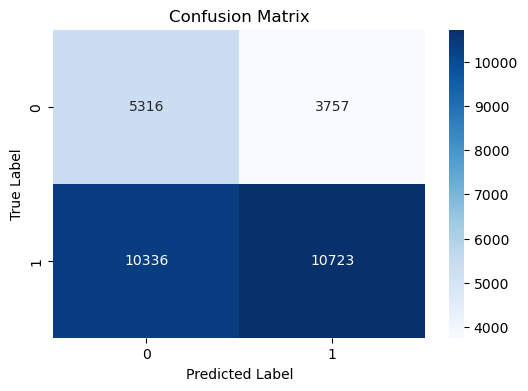

In [421]:
plt.hist(y_pred_hyper)
plt.xlim(0, 1)
plt.show()

y_pred_binary_hyper = (y_pred_hyper > 0.7).astype(int)  # binarize predictions based on histplot

accuracy = accuracy_score(y_test_hyper, y_pred_binary_hyper)
print(f"Accuracy: {accuracy}")

cm = confusion_matrix(y_test_hyper, y_pred_binary_hyper)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [166]:
y_pred_binary_hyper.value_counts()

0    14535
1     1353
dtype: int64

### 3. Model Evaluation & Interpretations

**1) Model Performance:**

- In sample:
    - R^2: 0.01639 for Obesity model, 0.00945 for Hypertension model
    > Very low R-squares suggest that the models do not fit the data well.  
    > Or that the IVs do not hold strong exlainatory power for DV. (Obesity & Hypertension do not have much to do with Ozempic and the confounders)
- Out of sample:
    - R^2: a lot higher than in-sample for both models
    - Accuracy: not having much meaning because all values are pushed to near 1 
    > The larger OOS R-squares validate that the model is a poor fit for the training data. The test data just happens to be a better fit than trainint data.  

**2) Model Interpretations:**

After capturing the confounders' effect on treatment by including d_hat in our model, the estimates of Ozempic reveals the real treatment effect that we're interested in:  
- Ozempic (Treatment Effect): p-value indicates that the treatment effect of Ozempic is statistically significant in determining both Obesity and Hypertension.
    - Obesity: coefficient = 0.4033, suggesting that using Ozempic can increase the odds of curing Obesity by multipling exp(0.4033) = 1.4967;  
    - Hypertension: coefficient = 0.2427, suggesting that using Ozempic can increase the odds of curing Hypertension by multipling exp(0.2427) = 1.2746.
    > From the dataset we have, it can be concluded that probably Ozempic is more effective on treating Obesity than Hypertension.  

- d_hat (Lasso predicted treatment values): p-value indicates that the confounders' effect on treatment is statistically significant in predicting curing Obesity but not Hypertension.
    - Obesity: coefficient = 5.3475, suggesting that the confounders that influence treatment also has a positive effect on curing Obesity, incresing its odds by multipling exp(5.3475) = 210.082;  
    - Hypertension: coefficient = -1.0771, suggesting that the confounders that influence treatment has an **negative** effect on curing Hypertension, increasing its odds by multipling exp(-1.0771) = 0.3405. But this effect is not statistically significant.    
    > This finding coincides with the Treatment effect, suggesting that Ozempic is less effective for patients with Hypertension than with Obesity.  

*However, these interpretations are not trustworthy given the poor model performance.*

## 6  Additional Insights

### 1. Patient Age: on Obesity
From the Logistic Regression result above, patient_age shows a significant positive effect on curing Obesity.

Why is that?

In [437]:
data_obes.groupby(['Ozempic','obes_cured']).agg({'patient_age':['min','mean','median','max']})

patient_age                        
                           min       mean median   max
Ozempic obes_cured                                    
0       0                 40.0  58.617043   60.0  75.0
        1                 40.0  59.664271   60.0  75.0
1       0                 40.0  57.743719   60.0  75.0
        1                 40.0  58.725562   60.0  75.0

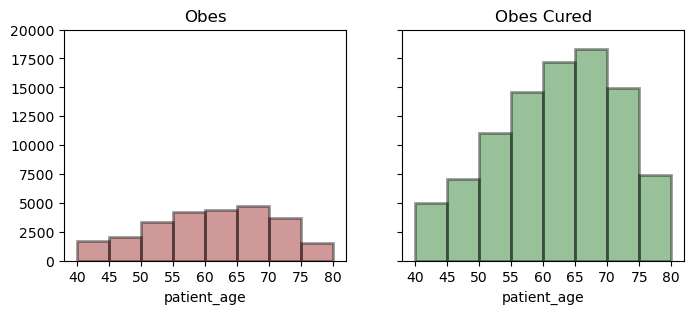

In [440]:
sick_age = data_obes[data_obes['obes_cured']== 0]['patient_age'] # subset with males age
cured_age = data_obes[data_obes['obes_cured']== 1]['patient_age'] # subset with females age

age_bins = range(40,81,5)
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3), sharey=True)

sns.distplot(sick_age, bins=age_bins, kde=False, color='darkred', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(age_bins)
ax1.set_ylim(top=20000)
ax1.set_title('Obes')

sns.distplot(cured_age, bins=age_bins, kde=False, color='darkgreen', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(age_bins)
ax2.set_title('Obes Cured')

plt.show()

> The age distribution of patients whose obesity cured is more left skewed,  
> which influences the model and causing the patient_age coeffcient to be positive.

### 2. Patient Short Zip: 852-857, 900-913
- 852-857: AZ
- 900-913: CA

In [433]:
temp_1 = data_patients.query("patient_state == 'AZ' | patient_state == 'CA'").groupby(['patient_state','Ozempic','obes_cured','hyper_cured'])['journey_id'].count().reset_index(name='count')
temp_2 = temp_1.groupby(['patient_state','Ozempic'])['count'].sum().reset_index(name='total_count')
temp_3 = pd.merge(temp_1, temp_2, on=['patient_state','Ozempic'], how='left')
temp_3['proportion'] = temp_3['count'] / temp_3['total_count']

,patient_state,Ozempic,obes_cured,hyper_cured,count,total_count,proportion
0,AZ,0,0,0,2118,9703,0.218283
1,AZ,0,0,1,3274,9703,0.337421
2,AZ,0,1,0,1088,9703,0.112130
3,AZ,0,1,1,3223,9703,0.332165
4,AZ,1,0,0,20,235,0.085106
5,AZ,1,0,1,80,235,0.340426
6,AZ,1,1,1,135,235,0.574468
7,CA,0,0,0,69109,415159,0.166464
8,CA,0,0,1,92784,415159,0.223490
9,CA,0,1,0,71770,415159,0.172874


> Patients in AZ and CA show a increase proportion pattern in obes_cured for those who use Ozempic,  
> which proves the effectiveness of Ozempic, causing their coefficients to be positive.  

> However for hyper_cured, the pattern is not that obvious,  
> leading to the coefficients of these short zips diverse between positive and negative.

## 7. Suggestions for further research:

#### 1. Data Preprocessing
From the analyses above, we can see that the original distribution of the data has strong influence on the modeling result.  

> Further analysis on this dataset can focus on more robust scaler method to achieve more accurate measurement.

#### 2. Including more enriched datasets
The choice of y variables is reasonable but still not a best determination of whether or not the patients have obesity or hypertension.  

> Adding datasets that contains more information may help improve the result.

##